In [3]:
import sys
for entry in sys.path:
    if 'python2.7' in entry:
        sys.path.remove(entry)

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [1]:
cd youtube_action_train_data

/Users/khanh94/Downloads/youtube_action_train_data


In [2]:
import pickle
import os.path

#Load the training and testing data from the pickle files
train_data_file = "youtube_action_train_data_part1.pkl"
test_data_file = "test_data.pkl"
train_label_file = "train_out.pkl"
test_label_file = "test_out.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
data = bytearray(n_bytes)

## write
#bytes_out = pickle.dumps(data)
#with open(file_path, 'wb') as f_out:
#    for idx in range(0, n_bytes, max_bytes):
#        f_out.write(bytes_out[idx:idx+max_bytes])

## read
train_data = bytearray(0)
input_size = os.path.getsize(train_data_file)
with open(train_data_file, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        train_data += f_in.read(max_bytes)
train_data = pickle.loads(train_data)

test_data = bytearray(0)
input_size = os.path.getsize(test_data_file)
with open(test_data_file, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        test_data += f_in.read(max_bytes)
test_data = pickle.loads(test_data)

FileNotFoundError: [Errno 2] No such file or directory: 'youtube_action_train_data_part1.pkl'

In [6]:
#Load the training and testing labels from the pickle file
train_label = bytearray(0)
input_size = os.path.getsize(train_label_file)
with open(train_label_file, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        train_label += f_in.read(max_bytes)
train_label = pickle.loads(train_label)

test_label = bytearray(0)
input_size = os.path.getsize(test_label_file)
with open(test_label_file, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        test_label += f_in.read(max_bytes)
test_label = pickle.loads(test_label)

In [7]:
train_data.shape
test_data.shape

(2400, 10, 64, 64, 3)

In [8]:
train_label.shape

(5600, 10, 7, 2)

In [9]:
test_label.shape

(2400, 10, 7, 2)

In [10]:
num_units = 128
batch_size = 4

In [11]:
#Placeholders
X = tf.placeholder(shape=[None, 10, 64, 64, 3], dtype=tf.float32)
Y_ = tf.placeholder(shape=[None, 10, 7, 2], dtype=tf.float32)
lr = tf.placeholder(dtype=tf.float32)

In [12]:
#Construct the Convolutional Neural Network
conv1 = tf.layers.conv3d(inputs=X, filters=32, kernel_size=[1,5,5], strides=(1, 1, 1), padding='valid', activation=tf.nn.relu)
conv1.shape
pool2 = tf.layers.max_pooling3d(inputs=conv1, pool_size=[1, 2, 2], strides=(1, 2, 2))
pool2.shape

TensorShape([Dimension(None), Dimension(10), Dimension(30), Dimension(30), Dimension(32)])

In [13]:
conv2 = tf.layers.conv3d(inputs=pool2, filters=32, kernel_size=[1,5,5], strides=(1, 1, 1), padding='valid', activation=tf.nn.relu)
conv2.shape

TensorShape([Dimension(None), Dimension(10), Dimension(26), Dimension(26), Dimension(32)])

In [14]:
pool3 = tf.layers.max_pooling3d(inputs=conv2, pool_size=[1, 2, 2], strides=(1, 2, 2))
pool3.shape

TensorShape([Dimension(None), Dimension(10), Dimension(13), Dimension(13), Dimension(32)])

In [15]:
conv4 = tf.layers.conv3d(inputs=pool3, filters=64, kernel_size=[1,3,3], strides=(1, 1, 1), padding='valid', activation=tf.nn.relu)
conv4.shape

TensorShape([Dimension(None), Dimension(10), Dimension(11), Dimension(11), Dimension(64)])

In [16]:
pool5 = tf.layers.max_pooling3d(inputs=conv4, pool_size=[1, 2, 2], strides=(1, 2, 2))

In [17]:
pool5.shape

TensorShape([Dimension(None), Dimension(10), Dimension(5), Dimension(5), Dimension(64)])

In [18]:
fully_connected = tf.reshape(pool5, (-1, 10, 1600))
fully_connected.shape

TensorShape([Dimension(None), Dimension(10), Dimension(1600)])

In [19]:
rnn_input = tf.layers.dense(inputs=fully_connected, units=num_units, activation=tf.nn.relu)
rnn_input.shape

TensorShape([Dimension(None), Dimension(10), Dimension(128)])

In [20]:
lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units)
h_val, _ = tf.nn.dynamic_rnn(lstm_cell, rnn_input, dtype=tf.float32)

In [2]:
#Feed the input to the RNN
seq_length = 30
final_output = tf.zeros(shape=[tf.shape(X)[0], 0, 14])
w_fc = tf.Variable(tf.truncated_normal([num_units, 14], stddev=0.1), name='final_weight')
b_fc = tf.Variable(tf.constant(0.1, tf.float32, [14]), name='last_bias')
for i in np.arange(seq_length):
    temp = tf.reshape(h_val[:, i, :], [-1, num_units])
    output = tf.matmul(temp, w_fc) + b_fc
    output = tf.reshape(output, [-1, 1, 14])
    final_output = tf.concat([final_output, output], axis=1)

NameError: name 'tf' is not defined

In [22]:
final_output.shape

TensorShape([Dimension(None), Dimension(10), Dimension(14)])

In [23]:
final_output = tf.reshape(final_output, (-1, 10, 7, 2))

In [39]:
#Calculate the mean squared loss and the average pixel distance for each image
mean_squared_loss = tf.losses.mean_squared_error(labels=Y_, predictions=final_output)
distance = tf.sqrt(tf.reduce_sum(tf.subtract(final_output, Y_)**2, axis = 3))
average_distance = tf.reduce_mean(tf.reduce_mean(distance, axis = 1), axis = 0)
average_distance.shape

TensorShape([Dimension(7)])

In [25]:
# training step, the learning rate is a placeholder
train_step = tf.train.AdamOptimizer(lr).minimize(mean_squared_loss)

In [55]:
#Get the relevant nodes and errors
import math
import numpy as np

tf.get_collection("validation_nodes")
# Add stuff to the collection.
tf.add_to_collection("validation_nodes", X)
tf.add_to_collection("validation_nodes", Y_)
tf.add_to_collection("validation_nodes", final_output)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
training_epochs = 2500
learning_rate = 0.0008 

#Get training error and losses
training_error = []
testing_error = []
training_loss = []
testing_loss = []
training_joint_distance = []
testing_joint_distance = []

for i in range(training_epochs):
    indices = np.random.randint(train_data.shape[0], size = 4)
    batch_X = train_data[indices]
    batch_Y = train_label[indices]
    
    test_indices = np.random.randint(test_data.shape[0],size = 100)
    test_batch_X = test_data[test_indices]
    test_batch_Y = test_label[test_indices]

    # compute training values
    if i % 10 == 0:
        '''
        When we sess.run here, we are calculating the accuracy and cross_entropy of the model on batch_X and batch_Y (ie. on 100 pieces of data)
        '''
        train_l, train_d = sess.run([mean_squared_loss, average_distance], {X: batch_X, Y_: batch_Y})
        #temp = sess.run([correct_prediction], feed_dict={X: batch_X, Y_: batch_Y})
        print(str(i) + " training loss: " + str(train_l) + " (lr:" + str(learning_rate) + ")")
        #training_error.append(train_l)
        training_loss.append(train_l)
        training_joint_distance.append(train_d)
 
    # compute test values
    if i % 20 == 0:
        '''
        When we sess.run here, we are calculating the accuracy and cross_entropy of the model on all of the data
        '''
        test_l, test_d = sess.run([mean_squared_loss, average_distance], {X: test_batch_X, Y_: test_batch_Y})
        print(test_d)
        print(str(i) + " test loss: " + str(test_l))
        #testing_error.append(1 - a)
        testing_loss.append(test_l)
        testing_joint_distance.append(list(test_d))
        
    # the backpropagation training step
    sess.run(train_step, {X: batch_X, Y_: batch_Y, lr: learning_rate})

    if i % 1000 == 0:
        saver = tf.train.Saver()
        save_path = saver.save(sess, "/Users/khanh94/Downloads/my_model_" + str(i))

0 training loss: 842.066 (lr:0.0008)
[ 36.81301117  44.47809982  54.71934891  44.51289368  55.26139832
  38.34843826  45.72595596]
0 test loss: 1093.98
10 training loss: 851.002 (lr:0.0008)
20 training loss: 812.326 (lr:0.0008)
[ 32.54631042  38.35795593  49.62756729  39.97473526  49.19489288
  35.4987793   41.8002243 ]
20 test loss: 888.445
30 training loss: 804.661 (lr:0.0008)
40 training loss: 780.846 (lr:0.0008)
[ 29.88226891  37.12385559  47.61646652  37.73807526  47.14468384
  33.52452469  39.76183701]
40 test loss: 804.751
50 training loss: 633.242 (lr:0.0008)
60 training loss: 609.308 (lr:0.0008)
[ 28.13665771  35.31553268  45.83029938  36.22495651  45.68645859
  31.44199181  37.80857086]
60 test loss: 738.271
70 training loss: 624.848 (lr:0.0008)
80 training loss: 614.849 (lr:0.0008)
[ 25.57921219  33.19661331  43.70502472  33.21260071  43.1999321
  28.81017876  35.40890884]
80 test loss: 653.503
90 training loss: 472.107 (lr:0.0008)
100 training loss: 473.911 (lr:0.0008)
[ 24

In [56]:
#Plotting the training and testing losses
plt.subplot(2,1,1)
plt.plot(training_loss, '-o', label='Training_Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(ncol=2, loc='upper right')
plt.subplot(2,1,2)
plt.plot(testing_loss, '-o', label='Testing_Loss')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(ncol=2, loc='lower right')
plt.gcf().set_size_inches(10, 10)
plt.savefig('Training_and_testing_loss.png')

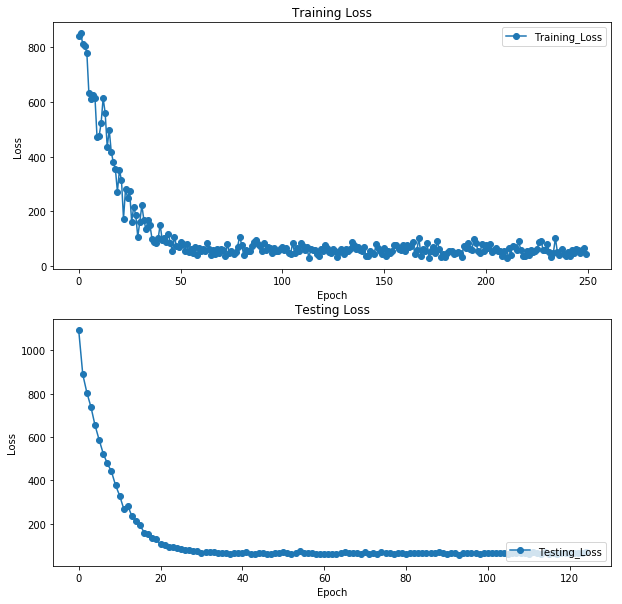

In [57]:
plt.show()